In [1]:
%load_ext autoreload
%autoreload 2
%load_ext ipython_memory_usage

Enabling IPython Memory Usage, use %imu_start to begin, %imu_stop to end


In [2]:
from neuralop.training.callbacks import BasicLoggerCallback,  Callback
import matplotlib.pyplot as plt

class DisplayCallback(Callback):
    def __init__(self, model, x, y):
        super().__init__()
        self.x = x
        self.y = y.detach().numpy()
        self.model = model
    
    def on_epoch_end(self, epoch, train_err, avg_loss):
        out = self.model(self.x).detach().numpy()
        plt.imshow(out[0,0])
        plt.colorbar()
        plt.show()

        plt.imshow(self.y[0,0])
        plt.colorbar()
        plt.show()

In [5]:
import torch
import sys
import time
import wandb
from MachineLearning.pytorch_dataset import get_pytorch_dataloader

from neuralop.models import FNO2d, UNO
from neuralop import Trainer
from neuralop import LpLoss, H1Loss
import torch.nn.functional as F

def train_fno(model_name, data_folder, model_config, training_config):

    model = FNO2d(16, 16, in_channels=1, hidden_channels=64, projection_channels=32)
    unique_model_name = '{}_{}'.format(model_name, str(time.time()))
    local_save_path = 'models/{}.keras'.format(unique_model_name)

    # Start a run, tracking hyperparameters
    wandb.init(
        # set the wandb project where this run will be logged
        project="EMPIRIC2-AI-emulator",

        # track hyperparameters and run metadata with wandb.config
        config=training_config
    )

    ## track the model with an artifact
    model_artifact = wandb.Artifact(
        unique_model_name,
        type="model",
        metadata={
            "save_path": local_save_path,
            "model_config": model_config,
            "param_count": None
        }
    )

    wandb.run.log_artifact(model_artifact)

    # [optional] use wandb.config as your config
    config = wandb.config

    ## track the dataset used with an artifact
    data_artifact = wandb.Artifact(
        "processed_data",
        type="dataset",
        metadata={
            "source": "local dataset",
            "data_folder": data_folder,
            "batch_size": config.batch_size,
            "input_description": "[-1, 1] normalized 'genesis_grids'",
            "output_description": "Mean Tropical Cyclone counts over 10 years"
        }
    )

    wandb.watch(model, log='all', log_freq=1)
    
    ## save the train file and unet file so that we can load the model later
    wandb.run.log_code(".", include_fn=lambda p, r: p.endswith("train.py") or p.endswith("unet.py"))

    train_data = get_pytorch_dataloader(data_folder, min_category=3, max_category=5, batch_size=config.batch_size, n_samples=32)
    test_data = get_pytorch_dataloader(data_folder, dataset="test", min_category=3, max_category=5, batch_size=config.batch_size, n_samples=1)
    one_sample = next(iter(train_data))
    
    device = 'cpu'
    # %%
    # Create the optimizer
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=1e-3,
                                 )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

    # %%
    # Creating the losses
    l2loss = LpLoss(d=2, p=2)
    h1loss = H1Loss(d=2)

    train_loss = l2loss
    eval_losses = {'h1': h1loss, 'l2': l2loss}

    # %%

    print('\n### MODEL ###\n', model)
    print('\n### OPTIMIZER ###\n', optimizer)
    print('\n### SCHEDULER ###\n', scheduler)
    print('\n### LOSSES ###')
    print(f'\n * Train: {train_loss}')
    print(f'\n * Test: {eval_losses}')
    sys.stdout.flush()

    # %%
    # Create the trainer
    trainer = Trainer(model=model, n_epochs=10,
                      device=device,
                      wandb_log=True,
                      log_test_interval=1,
                      use_distributed=False,
                      log_output=True,
                      verbose=True,
                      callbacks=[BasicLoggerCallback(),  DisplayCallback(model, one_sample['x'], one_sample['y'])]
                      )

    # %%
    # Actually train the model on our small Darcy-Flow dataset

    trainer.train(train_loader=train_data,
                  test_loaders={32: test_data},
                  optimizer=optimizer,
                  scheduler=scheduler,
                  regularizer=False,
                  training_loss=train_loss,
                  eval_losses=eval_losses)

    torch.save(model.state_dict(), local_save_path)

TRAINING_CONFIG = {
            "Name": "one-batch",
            "optimizer": "adam",
            "loss": "mean_squared_error",
            "metric": "mean_absolute_error",
            "learning_rate": 0.003,
            "epoch": 10,
            "batch_size": 32
        }

MODEL_CONFIG = {
    "genesis_size": (112, 224, 1),
    "output_size": (110, 210, 1),
    "kernel_size": (5,5),
    "dropout": False,
    "batch_norm": True,
    "down_filters": [8, 16, 32],
    "up_filters": [32, 16, 8]
}

32_h1,█▇▆▅▃▂▁
32_l2,█▇▆▅▃▂▁
avg_loss,█▇▆▅▃▂▁
lr,██▇▆▄▃▁
time,█▂▃▁▄▄▄
train_err,█▇▆▅▃▂▁
32_h1,0.96891
32_l2,1.00847
avg_loss,3.37041
lr,0.00026
time,16.26688


wandb: WARNING No relevant files were detected in the specified directory. No code will be logged to your run.



### MODEL ###
 FNO2d(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexDenseTensor(shape=torch.Size([64, 64, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(1, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.losses.da

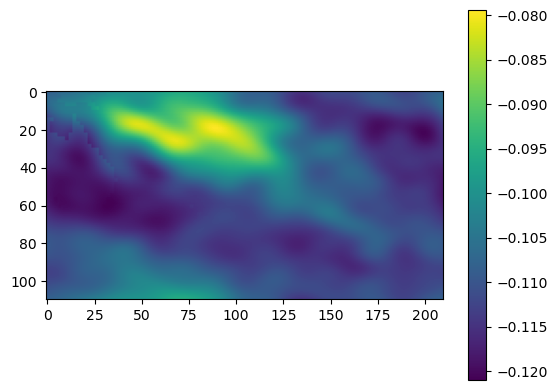

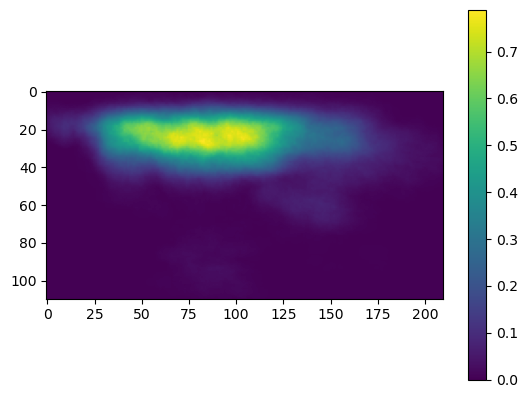

[1] time=16.37, avg_loss=4.2602, train_err=42.6017, 32_h1=0.9834, 32_l2=1.0880


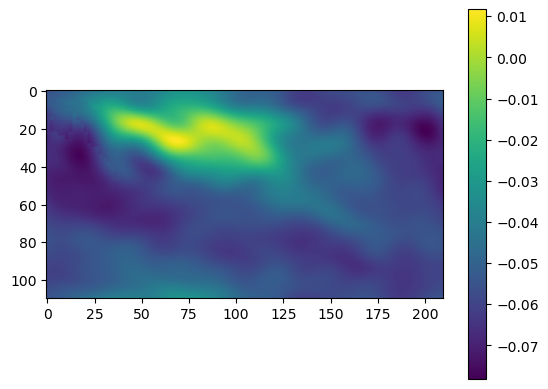

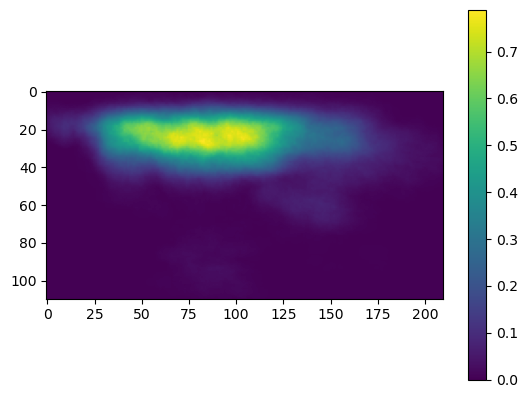

[2] time=16.50, avg_loss=3.4874, train_err=34.8744, 32_h1=0.8791, 32_l2=0.8309


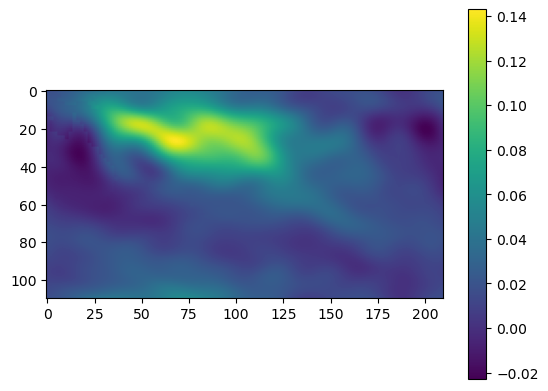

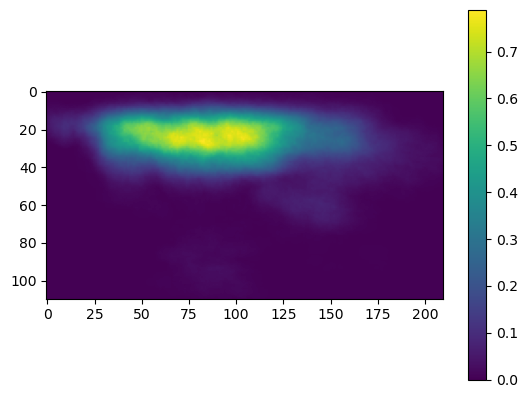

[3] time=16.10, avg_loss=2.6467, train_err=26.4667, 32_h1=0.8058, 32_l2=0.7321


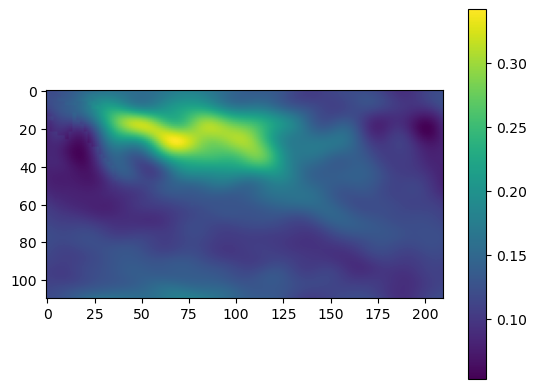

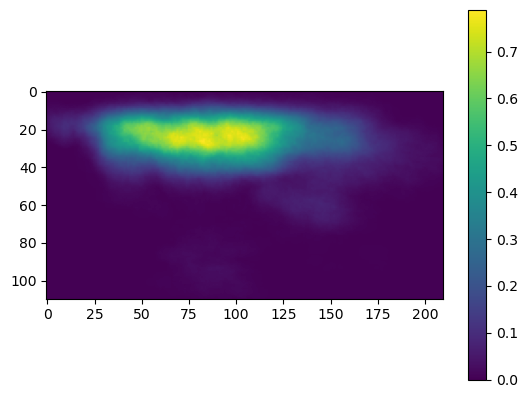

[4] time=16.25, avg_loss=2.3287, train_err=23.2869, 32_h1=0.7529, 32_l2=0.7571


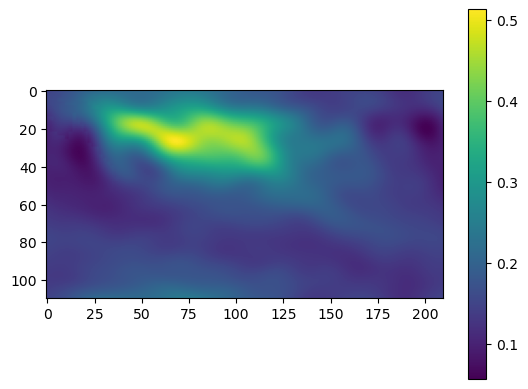

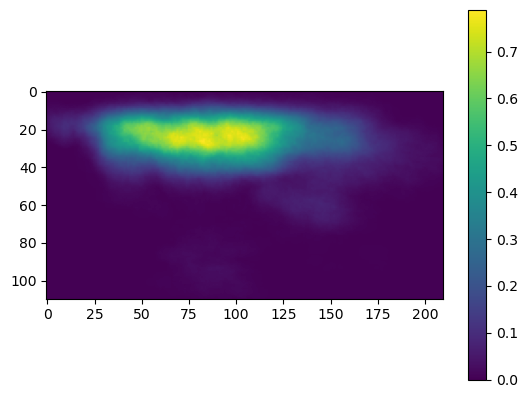

[5] time=16.28, avg_loss=2.4214, train_err=24.2140, 32_h1=0.6546, 32_l2=0.5790


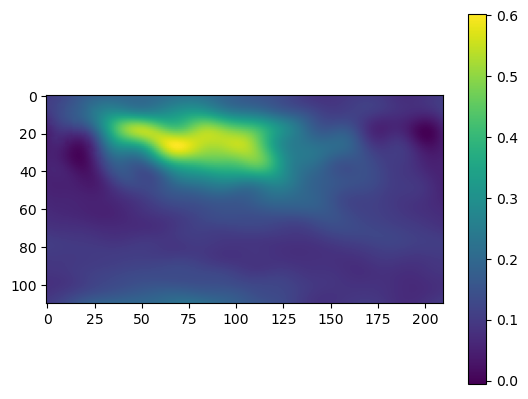

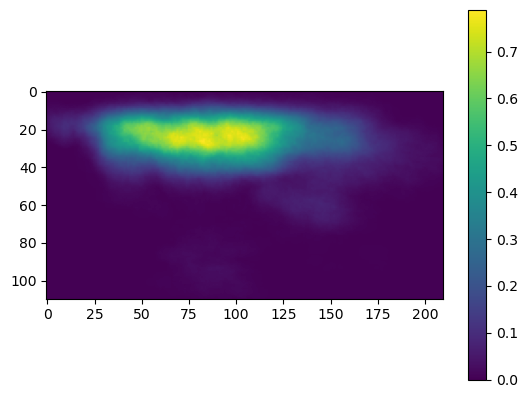

[6] time=16.03, avg_loss=1.8499, train_err=18.4991, 32_h1=0.5642, 32_l2=0.3844


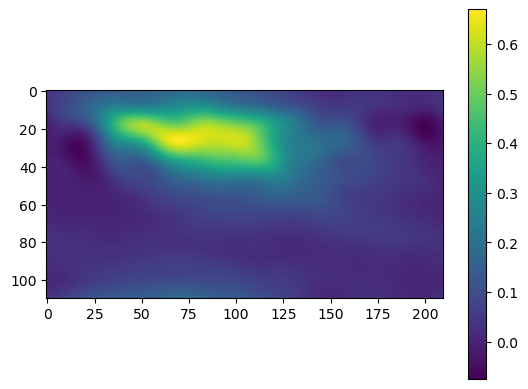

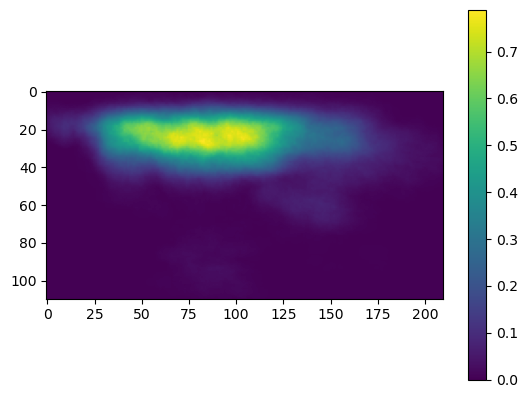

[7] time=16.38, avg_loss=1.2323, train_err=12.3233, 32_h1=0.5029, 32_l2=0.2983


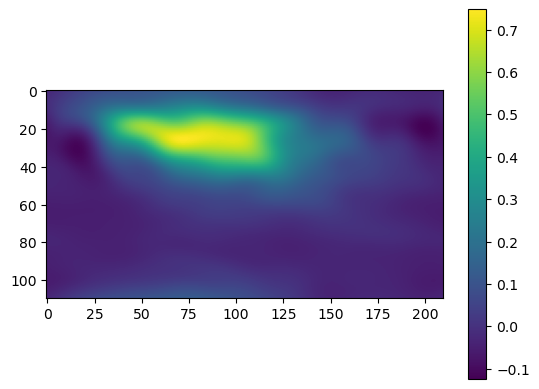

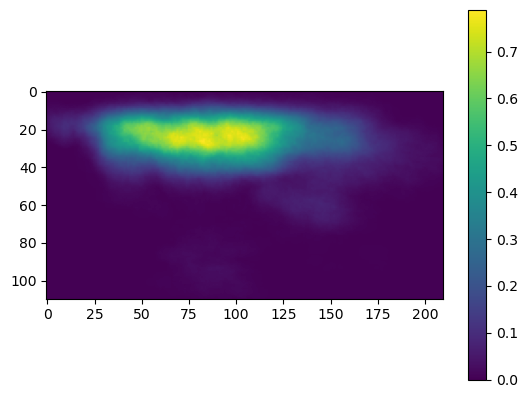

[8] time=16.32, avg_loss=0.9900, train_err=9.8999, 32_h1=0.4642, 32_l2=0.2947


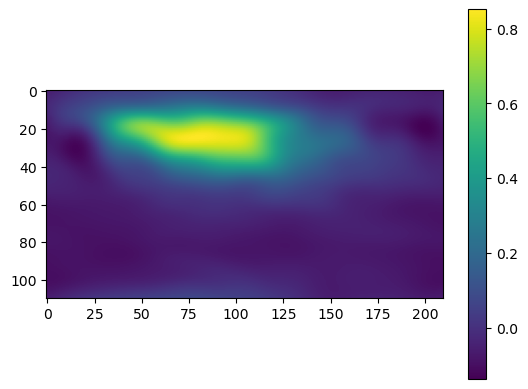

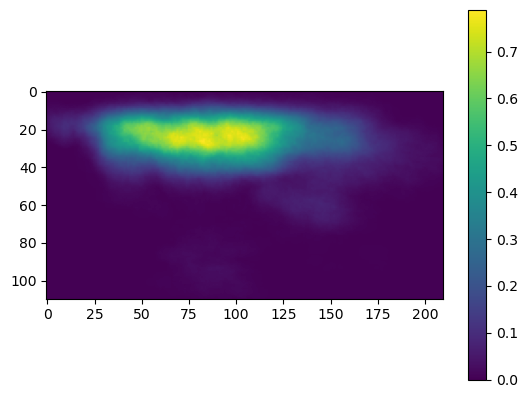

[9] time=16.13, avg_loss=1.0208, train_err=10.2083, 32_h1=0.4418, 32_l2=0.3004


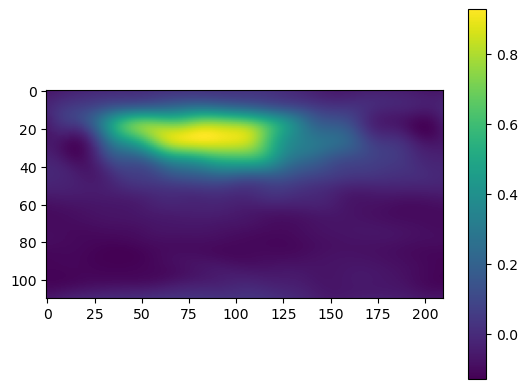

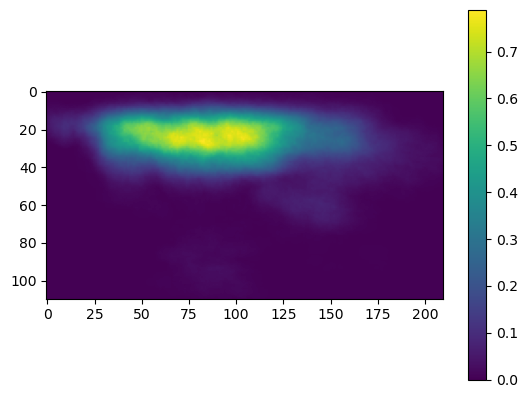

RuntimeError: Parent directory models does not exist.

In [6]:
train_fno(
        'FNO',
        '/users/ewinkelm/data/ewinkelm',
        MODEL_CONFIG,
        TRAINING_CONFIG
)

In [1]:
import sys
import numpy as np
sys.path.append("../")

In [2]:
from saved_models.saved_models import FNO_model
model = FNO_model()

2024-10-20 16:39:44.720054: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-20 16:39:46.330933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 16:39:46.330991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 16:39:46.605903: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 16:39:47.222722: I tensorflow/core/platform/cpu_feature_guar

In [4]:
from MachineLearning.pytorch_dataset import get_pytorch_dataloader
test_data = get_pytorch_dataloader('/users/ewinkelm/data/ewinkelm', dataset="test", batch_size=2, n_samples=10)

In [10]:
def predict(model, dataloader):
        prediction_list = []
        for i, batch in enumerate(dataloader):
            pred = model(batch['x'])
            prediction_list.append(pred)
        return np.concatenate(prediction_list, axis=0)

In [11]:
predict(model, test_data)

array([[[ 0.11743213,  0.13306649,  0.14381567, ...,  0.07808889,
          0.07290778,  0.07766102],
        [ 0.15413108,  0.1954701 ,  0.22640838, ...,  0.04940449,
          0.05622385,  0.08008385],
        [ 0.22057162,  0.2824241 ,  0.32693332, ...,  0.03337926,
          0.04984378,  0.08994095],
        ...,
        [ 0.0591165 ,  0.01507544, -0.01505942, ...,  0.19694944,
          0.1571303 ,  0.10930926],
        [ 0.06013035,  0.03137659,  0.01235477, ...,  0.15585573,
          0.12620395,  0.09332688],
        [ 0.07095206,  0.06330776,  0.06027808, ...,  0.11498258,
          0.09717622,  0.08230697]],

       [[ 0.12538087,  0.14036864,  0.15194586, ...,  0.09398855,
          0.08733786,  0.0903164 ],
        [ 0.16422871,  0.2037132 ,  0.23471713, ...,  0.07283462,
          0.07707869,  0.09779139],
        [ 0.22722995,  0.2871088 ,  0.33082378, ...,  0.06308876,
          0.07652911,  0.1122667 ],
        ...,
        [ 0.06182283,  0.02036409, -0.00800063, ...,  

In [5]:
batch_axis = 0

unbatched_inputs = np.concatenate(
        list(ml_inputs.as_numpy_iterator()), axis=batch_axis
)

/users/ewinkelm/data/ewinkelm/AllData_1725501397.4963796.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725501397.5590131.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725507058.2230408.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725509553.326823.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725512579.4807749.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725515224.7177584.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725520640.4419153.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725523281.9845803.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725528817.5241702.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725531343.1752932.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725536630.2714288.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725537350.9967282.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725840757.2216623.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725840764.9880579.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725845876.3939693.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725846331.3849988.hdf5
/users/ew

In [6]:
batched_inputs = np.array((list(ml_inputs.as_numpy_iterator())))


/users/ewinkelm/data/ewinkelm/AllData_1726072070.9867613.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1726164605.8071325.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1726093735.4941268.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1726244654.2761295.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725501397.4963796.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725877178.4030898.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1726228261.1981206.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1726186192.1846895.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1726239068.4708295.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1726148196.381988.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1726050973.4840193.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1726144574.3586934.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1726142768.6233768.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1726063461.3399127.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1726068820.3684912.hdf5
/users/ewinkelm/data/ewinkelm/AllData_1725509553.326823.hdf5
/users/ewi

In [8]:
import torch
inp = torch.from_numpy(np.transpose(batched_inputs, (0, 1, 4, 2, 3)))
print(inp.shape)

torch.Size([123, 1, 1, 110, 210])


In [18]:
model(inp)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [123, 1, 1, 110, 210]